## Image classification with Convolutional Neural Networks

Created a Earth Moon classifier using Fastai's notes from lesson 1 using convolutional neural networks.

(code and comments written here are provided by fast.ai at https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb)

## Classifying Earth and Moon

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/earthmoon/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

## First look at Moon pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [7]:
os.listdir(PATH)

['valid', 'models', 'train', 'tmp']

In [8]:
os.listdir(f'{PATH}valid')

['.DS_Store', 'Moon', 'Earth']

In [9]:
files = os.listdir(f'{PATH}valid/Moon')[:5]
files

['Moon23.jpg', 'Moon26.jpg', 'Moon22.jpg', 'Moon24.jpg', 'Moon25.jpg']

In [10]:
img = plt.imread(f'{PATH}valid/Moon/{files[0]}')

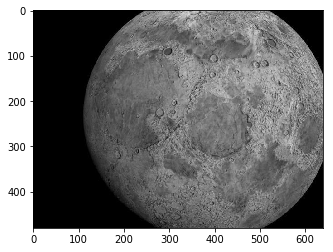

In [11]:
plt.imshow(img);

Here is how the raw data looks like

In [11]:
img.shape

(480, 640, 3)

In [12]:
img[:4,:4]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

## Our first model: quick start

Use a pre-trained model called resnet34

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [13]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy               
    0      1.157428   0.797996   0.5       
    1      0.931415   0.556952   0.7             



[array([0.55695]), 0.699999988079071]

## Looking at pictures

In [14]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [15]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['Earth', 'Moon']

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(10, 2)

In [17]:
log_preds[:10]

array([[-0.70649, -0.67998],
       [-0.30254, -1.34301],
       [-0.59511, -0.80185],
       [-0.36634, -1.18177],
       [-0.95047, -0.48867],
       [-1.49501, -0.25392],
       [-0.97702, -0.4723 ],
       [-0.34908, -1.22192],
       [-1.46505, -0.26275],
       [-1.03713, -0.43768]], dtype=float32)

In [18]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [19]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [20]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [21]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


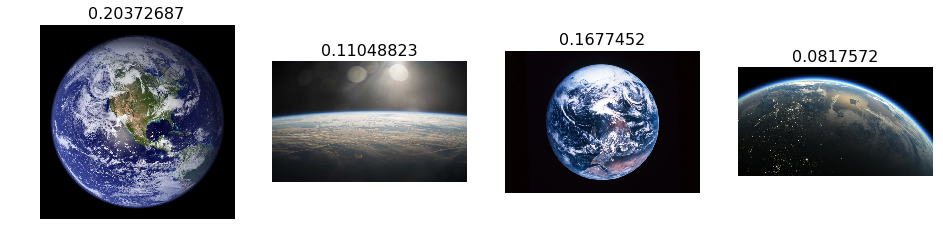

In [23]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


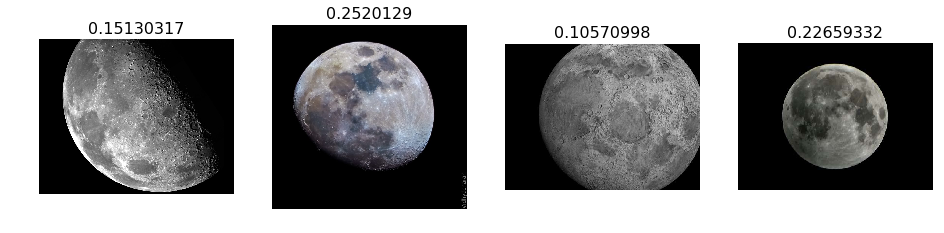

In [24]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [22]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct earth


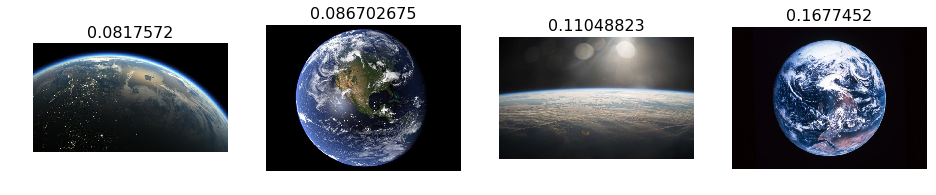

In [26]:
plot_val_with_title(most_by_correct(0, True), "Most correct earth")

In [27]:
plot_val_with_title(most_by_correct(1, True), "Most correct moon")

Most correct moon


<Figure size 1152x576 with 0 Axes>

In [28]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect moon")

Most incorrect moon


<Figure size 1152x576 with 0 Axes>

Most incorrect earth


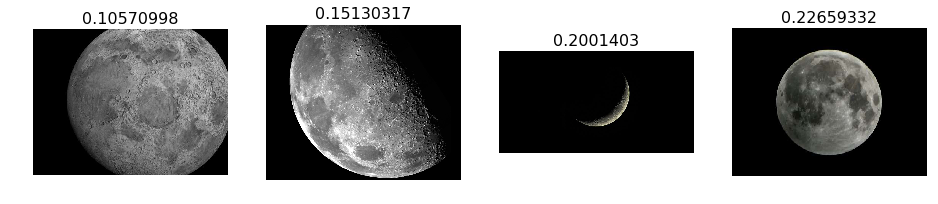

In [29]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect earth")

Most uncertain predictions


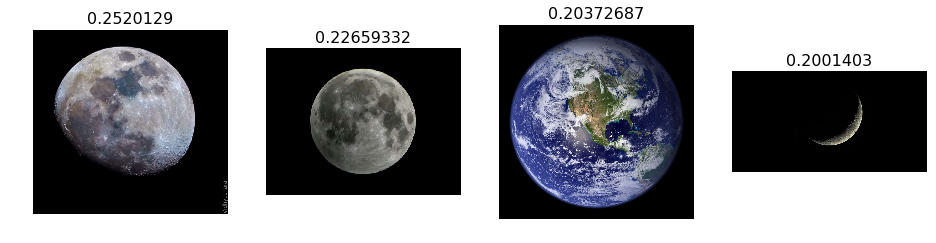

In [30]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

In [23]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [24]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy        
    0      0.756517   0.956912   0.6       



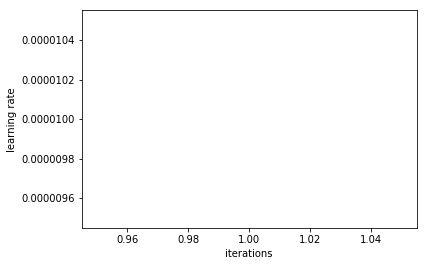

In [25]:
learn.sched.plot_lr()

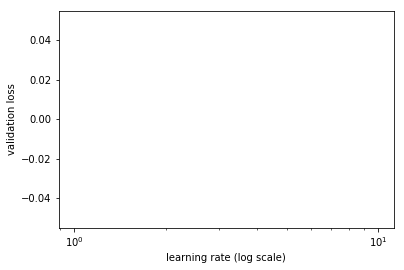

In [26]:
learn.sched.plot()

## Improving our model

### Data augmentation

In [27]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [28]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [29]:
ims = np.stack([get_augs() for i in range(6)])

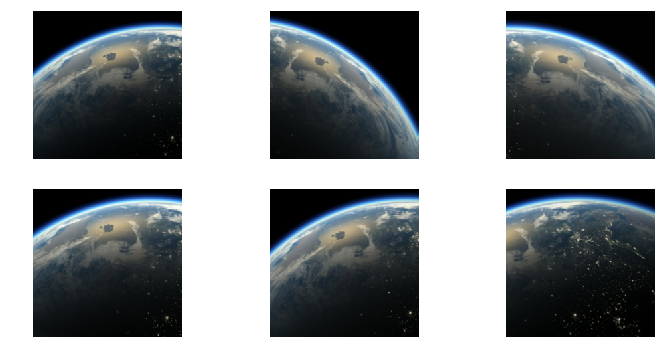

In [38]:
plots(ims, rows=2)

In [30]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [31]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy        
    0      0.855702   0.578112   0.7       



[array([0.57811]), 0.699999988079071]

In [32]:
learn.precompute=False

In [33]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.603985   0.583674   0.6       
    1      0.65125    0.574505   0.7                     
    2      0.685456   0.459521   0.7                     



[array([0.45952]), 0.699999988079071]

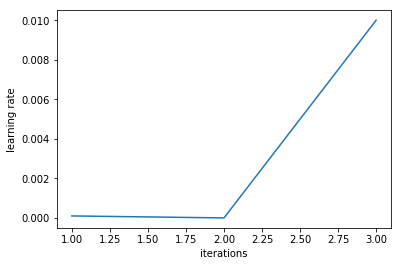

In [34]:
learn.sched.plot_lr()

In [35]:
learn.save('224_lastlayer_earthmoon')

In [36]:
learn.load('224_lastlayer_earthmoon')

### Fine-tuning and differential learning rate annealing

In [37]:
learn.unfreeze()

In [38]:
lr=np.array([1e-4,1e-3,1e-2])

In [39]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.55974    0.471661   0.8       
    1      0.604928   0.451529   0.9                     
    2      0.616091   0.364242   0.9                     
    3      0.589479   0.359425   0.9                     
    4      0.589537   0.271437   0.9                     
    5      0.536552   0.261495   0.9                     
    6      0.500874   0.183628   0.9                     



[array([0.18363]), 0.8999999761581421]

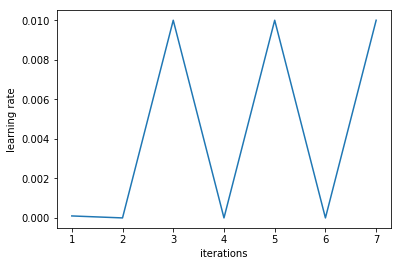

In [40]:
learn.sched.plot_lr()

In [41]:
learn.save('224_all_earthmoon')

In [42]:
learn.load('224_all_earthmoon')

In [43]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [44]:
accuracy_np(probs, y)

1.0

## Analyzing results

### Confusion matrix 

In [45]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[5 0]
 [0 5]]


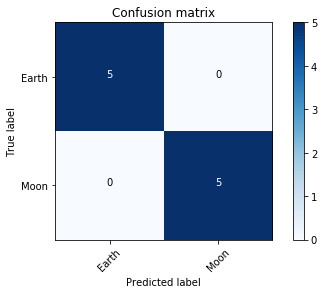

In [47]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [66]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Earth")

Most incorrect Earth


<Figure size 1152x576 with 0 Axes>

In [67]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Moon")

Most incorrect Moon


<Figure size 1152x576 with 0 Axes>

## Understanding the code for our first model

In [48]:
tfms = tfms_from_model(resnet34, sz)

In [49]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [50]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

In [53]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy        
    0      0.677774   0.43361    1.0       



[array([0.43361]), 1.0]

## Checking the results

Correctly classified


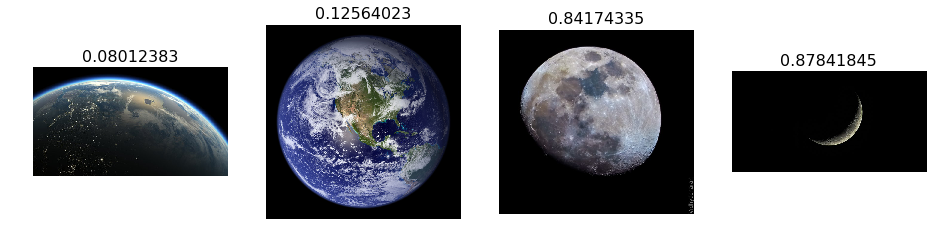

In [68]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [69]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

ValueError: a must be non-empty

Most correct earth


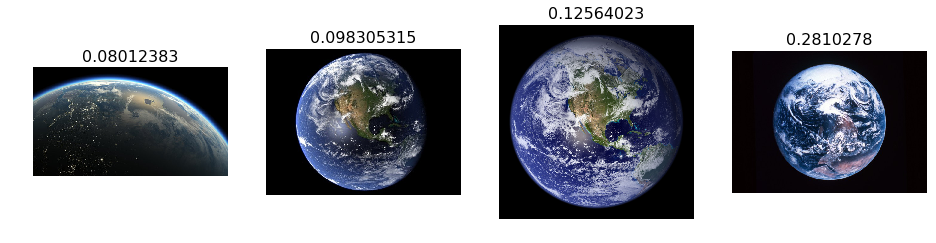

In [70]:
plot_val_with_title(most_by_correct(0, True), "Most correct earth")

Most correct moon


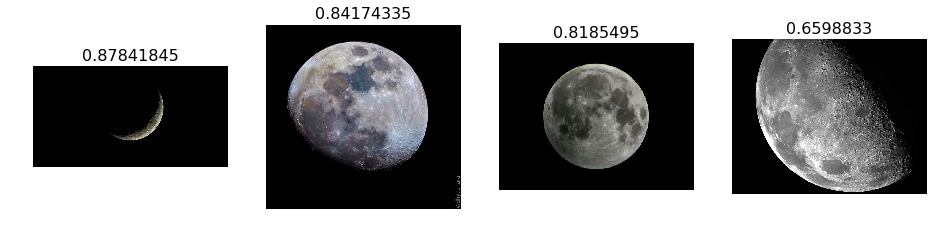

In [71]:
plot_val_with_title(most_by_correct(1, True), "Most correct moon")

In [72]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect moon")

Most incorrect moon


<Figure size 1152x576 with 0 Axes>

In [73]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect earth")

Most incorrect earth


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


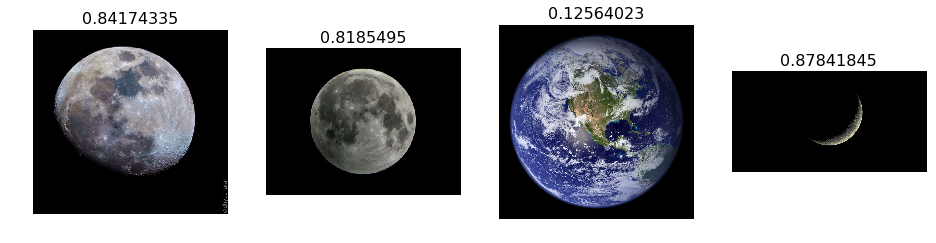

In [74]:
plot_val_with_title(most_uncertain, "Most uncertain predictions")